# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import ipaddress as ip
import pickle
import requests, bs4
from datetime import datetime
import re

In [3]:
pd.options.display.max_columns = 50

%matplotlib inline

# Importing Data and EDA

In [4]:
dataset = pd.read_csv('data.csv')

In [5]:
dataset.head()

,URL,Label
0,https://nih.gov,0
1,http://www.perfumemart.com/,0
2,http://chronopost-service-enligne.net/56123s/r...,1
3,http://wvw.micloudappel.security-updates-myacc...,1
4,http://colach8x.beget.tech/likon/mqnger/drwx/P...,1


In [6]:
len(dataset)

8000

In [7]:
dataset['Label'].value_counts()

0    4080
1    3920
Name: Label, dtype: int64

# Feature Generartion

##### Long URL to Hide the Suspicious Part
Phishers can use long URL to hide the doubtful part in the address bar. For example: 
http://federmacedoadv.com.br/3f/aze/ab51e2e319e51502f416dbe46b773a5e/?cmd=_home&amp;dispatch=11004d58f5b74f8dc1e7c2e8dd4105e811004d58f5b74f8dc1e7c2e8dd4105e8@phishing.website.html

In [8]:
length = lambda x : len(x)

##### 02. Using the IP Address
If an IP address is used as an alternative of the domain name in the URL, such as “http://125.98.3.123/fake.html”, users can be sure that someone is trying to steal their personal information. Sometimes, the IP address is even transformed into hexadecimal code as shown in the following link “http://0x58.0xCC.0xCA.0x62/2/paypal.ca/index.html”. 

If the domain part has an IP address -> Phishing

Otherwise -> Legitimate

In [9]:
def isIp(x):
    try:
        if ip.ip_address(x):
            return 1
    except:
        return 0

##### 03. URL’s having “@” Symbol
Using “@” symbol in the URL leads the browser to ignore everything preceding the “@” symbol and the real address often follows the “@” symbol. 

In [10]:
countAt = lambda x : x.count('@')

##### 04. Redirecting using “//”
The existence of “//” within the URL path means that the user will be redirected to another website. An example of such URL’s is: “http://www.legitimate.com//http://www.phishing.com”. We examin the location where the “//” appears. We find that if the URL starts with “HTTP”, that means the “//” should appear in the sixth position. However, if the URL employs “HTTPS” then the “//” should appear in seventh position.


In [11]:
countDoubleSlash = lambda x : x.count('//')

##### 05. Adding Prefix or Suffix Separated by (-) to the Domain
The dash symbol is rarely used in legitimate URLs. Phishers tend to add prefixes or suffixes separated by (-) to the domain name so that users feel that they are dealing with a legitimate webpage. For example http://www.Confirme-paypal.com/.


In [12]:
countHyphen = lambda x : x.count('-')

##### 06. Sub Domain and Multi Sub Domains
Let us assume we have the following link: http://www.hud.ac.uk/students/. A domain name might include the country-code top-level domains (ccTLD), which in our example is “uk”. The “ac” part is shorthand for “academic”, the combined “ac.uk” is called a second-level domain (SLD) and “hud” is the actual name of the domain. To produce a rule for extracting this feature, we firstly have to omit the (www.) from the URL which is in fact a sub domain in itself. Then, we have to remove the (ccTLD) if it exists. Finally, we count the remaining dots. If the number of dots is greater than one, then the URL is classified as “Suspicious” since it has one sub domain. However, if the dots are greater than two, it is classified as “Phishing” since it will have multiple sub domains. Otherwise, if the URL has no sub domains, we will assign “Legitimate” to the feature. 


In [13]:
countDots = lambda x: x.count('.')

##### 07. num of delimeters:
[';','_','?','=','&']

In [14]:
def countDelimeters(x):
    count = 0
    for delim in [';','_','?','=','&']:
        count += x.count(delim)
    return count

##### 08. subdirectory count

In [15]:
countSubDirectory = lambda x : len(re.findall(r"[\s/\s]", x))

##### 09. query count

In [16]:
def countQueries(x):
    if not x:
        return 0
    else:
        return len(x.split('&'))

##### 10. Domain Registration Length
Based on the fact that a phishing website lives for a short period of time, we believe that trustworthy domains are regularly paid for several years in advance. In our dataset, we find that the longest fraudulent domains have been used for one year only. 


In [17]:
to_datetime = lambda x : datetime(int(x.getText()[:4]), int(x.getText()[5:7]), int(x.getText()[8:]))

In [18]:
def domainRegistrationLength(x):
    try:
        res = requests.get('https://www.whois.com/whois/'+x)
        if res.status_code == requests.codes.ok:
            websitesoup = bs4.BeautifulSoup(res.text)
            elems = websitesoup.select('.df-value')
            regOn, expOn = elems[2:4]
            regOn = to_datetime(regOn)
            expOn = to_datetime(expOn)
            duration = (expOn - regOn).total_seconds()//31556926
            return int(duration)
        else:
            return -1
    except:
        return -1

##### 11. Alexa Global Rank

In [19]:
def alexaGlobalRank(x):
    try:
        res = requests.get('https://www.alexa.com/siteinfo/'+x)
        if res.status_code == requests.codes.ok:
            websitesoup = bs4.BeautifulSoup(res.text)
            elems = websitesoup.select('strong')
            elem = elems[0]
            if elem.getText() == "We don't have enough data to rank this website.":
                return -1
            else:
                elem = elems[6]
                return int(elem.getText().strip())**(-1)
        else:
            return -1
    except:
        return -1

##### 12. Bounce Rate
The percentage of visitors to a particular website who navigate away from the site after viewing only one page.

In [20]:
def bounceRate(x):
    try:
        res = requests.get('https://www.alexa.com/siteinfo/'+x)
        if res.status_code == requests.codes.ok:
            websitesoup = bs4.BeautifulSoup(res.text)
            elems = websitesoup.select('strong')
            elem = elems[0]
            if elem.getText() == "We don't have enough data to rank this website.":
                return -1
            else:
                elem = elems[49]
                return float(elem.getText().strip()[:-1])
        else:
            return -1
    except:
        return -1

##### 13. Daily Page Views Per Visitor

In [21]:
def dailyPageViewsPerVisitor(x):
    try:
        res = requests.get('https://www.alexa.com/siteinfo/'+x)
        if res.status_code == requests.codes.ok:
            websitesoup = bs4.BeautifulSoup(res.text)
            elems = websitesoup.select('strong')
            elem = elems[0]
            if elem.getText() == "We don't have enough data to rank this website.":
                return -1
            else:
                elem = elems[50]
                return float(elem.getText().strip())
        else:
            return -1
    except:
        return -1

##### 14. Daily Time on Site

In [22]:
def dailyTimeOnSite(x):
    try:
        res = requests.get('https://www.alexa.com/siteinfo/'+x)
        if res.status_code == requests.codes.ok:
            websitesoup = bs4.BeautifulSoup(res.text)
            elems = websitesoup.select('strong')
            elem = elems[0]
            if elem.getText() == "We don't have enough data to rank this website.":
                return -1
            else:
                elem = elems[51]
                t = elem.getText().strip()
                h = int(t[:-3])
                m = int(t[-2:])
                return ((h*60) + m)
        else:
            return -1
    except:
        return -1

##### 15. Search Visits
What percentage of visits to this site come from a search engine?

In [23]:
def searchVisits(x):
    try:
        res = requests.get('https://www.alexa.com/siteinfo/'+x)
        if res.status_code == requests.codes.ok:
            websitesoup = bs4.BeautifulSoup(res.text)
            elems = websitesoup.select('strong')
            elem = elems[0]
            if elem.getText() == "We don't have enough data to rank this website.":
                return -1
            else:
                elem = elems[56]
                return float(elem.getText().strip()[:-1])
        else:
            return -1
    except:
        return -1

##### 16. Total Sites Linking in
The number of websites in Alexa's crawl of the web that link to a given website.

In [24]:
def totalSitesLinkingIn(x):
    try:
        res = requests.get('https://www.alexa.com/siteinfo/'+x)
        if res.status_code == requests.codes.ok:
            websitesoup = bs4.BeautifulSoup(res.text)
            elems = websitesoup.select('strong')
            elem = elems[0]
            if elem.getText() == "We don't have enough data to rank this website.":
                return -1
            else:
                elem = elems[64]
                return float(elem.getText().strip().replace(',', ''))
        else:
            return -1
    except:
        return -1

In [25]:
def generateFeatures(x):
    features = []
    features.append(length(x))
    features.append(isIp(x))
    features.append(countAt(x))
    features.append(countDoubleSlash(x))
    features.append(countHyphen(x))
    features.append(countDots(x))
    features.append(countDelimeters(x))
    features.append(countSubDirectory(x))
    features.append(countQueries(x))
    features.append(domainRegistrationLength(x))
    features.append(alexaGlobalRank(x))
    features.append(bounceRate(x))
    features.append(dailyPageViewsPerVisitor(x))
    features.append(dailyTimeOnSite(x))
    features.append(searchVisits(x))
    features.append(totalSitesLinkingIn(x))    
    return features

In [26]:
drl = pd.read_csv('DomainRegistrationLength.csv')

In [27]:
agr = pd.read_csv('AlexaGlobalRank.csv')

In [28]:
br = pd.read_csv('BounceRate.csv')

In [29]:
dpvpv = pd.read_csv('DailyPageViewsPerVisitor.csv')

In [30]:
dtos = pd.read_csv('DailyTimeOnSite.csv')

In [31]:
sv = pd.read_csv('SearchVisits.csv')

In [32]:
tsli = pd.read_csv('TotalSitesLinkingIn.csv')

In [33]:
featureset = pd.DataFrame(dataset['URL'].copy())

In [34]:
featureset.head()

,URL
0,https://nih.gov
1,http://www.perfumemart.com/
2,http://chronopost-service-enligne.net/56123s/r...
3,http://wvw.micloudappel.security-updates-myacc...
4,http://colach8x.beget.tech/likon/mqnger/drwx/P...


In [35]:
featureset['length'] = featureset['URL'].apply(length)

In [36]:
featureset['isIp'] = featureset['URL'].apply(isIp)

In [37]:
featureset['countAt'] = featureset['URL'].apply(countAt)

In [38]:
featureset['countDoubleSlash'] = featureset['URL'].apply(countDoubleSlash)

In [39]:
featureset['countHyphen'] = featureset['URL'].apply(countHyphen)

In [40]:
featureset['countDots'] = featureset['URL'].apply(countDots)

In [41]:
featureset['countDelimeters'] = featureset['URL'].apply(countDelimeters)

In [42]:
featureset['countSubDirectory'] = featureset['URL'].apply(countSubDirectory)

In [43]:
featureset['countQueries'] = featureset['URL'].apply(countQueries)

In [44]:
featureset['domainRegistrationLength'] = drl['domainRegistrationLength']

In [45]:
featureset['alexaGlobalRank'] = agr['alexaGlobalRank']

In [46]:
featureset['bounceRate'] = br['bounceRate']

In [47]:
featureset['dailyPageViewsPerVisitor'] = dpvpv['dailyPageViewsPerVisitor']

In [48]:
featureset['dailyTimeOnSite'] = dtos['dailyTimeOnSite']

In [49]:
featureset['searchVisits'] = sv['searchVisits']

In [50]:
featureset['totalSitesLinkingIn'] = tsli['totalSitesLinkingIn']

In [51]:
featureset['label'] = dataset['Label']

In [52]:
featureset.head()

,URL,length,isIp,countAt,countDoubleSlash,countHyphen,countDots,countDelimeters,countSubDirectory,countQueries,domainRegistrationLength,alexaGlobalRank,bounceRate,dailyPageViewsPerVisitor,dailyTimeOnSite,searchVisits,totalSitesLinkingIn,label
0,https://nih.gov,15,0,0,1,0,1,0,2,1,-1,0.007874,57.4,3.23,236,57.3,155696.0,0
1,http://www.perfumemart.com/,27,0,0,1,0,2,0,3,1,-1,-1.000000,-1.0,-1.00,-1,-1.0,-1.0,0
2,http://chronopost-service-enligne.net/56123s/r...,116,0,0,1,2,1,0,8,1,-1,-1.000000,-1.0,-1.00,-1,-1.0,-1.0,1
3,http://wvw.micloudappel.security-updates-myacc...,75,0,0,1,2,3,0,5,1,-1,-1.000000,-1.0,-1.00,-1,-1.0,-1.0,1
4,http://colach8x.beget.tech/likon/mqnger/drwx/P...,139,0,0,1,0,3,3,11,1,4,-1.000000,-1.0,-1.00,-1,-1.0,-1.0,1


In [53]:
featureset.to_csv('featureset.csv', index=False)

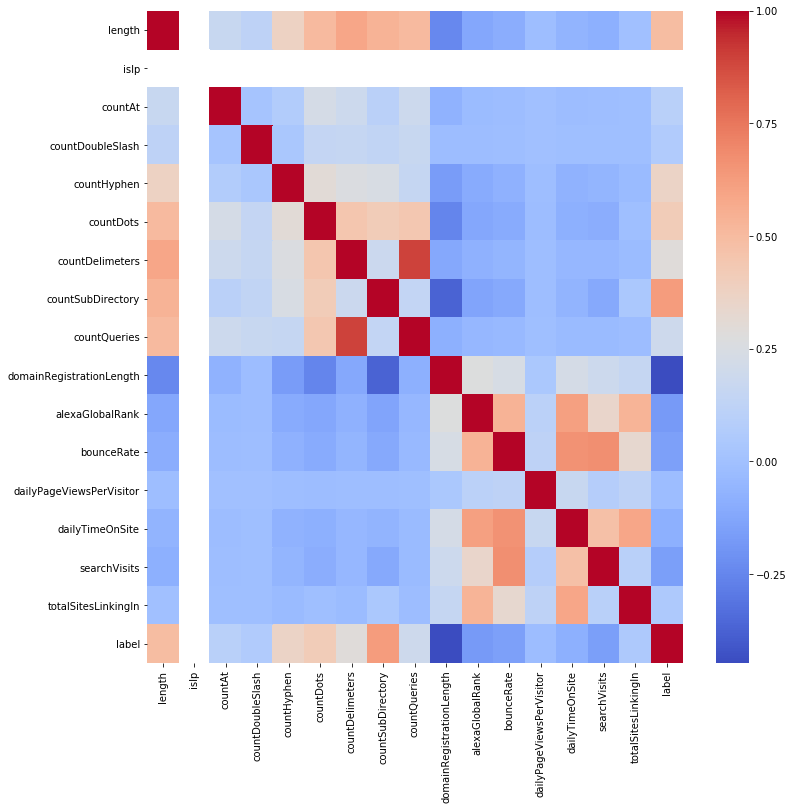

In [54]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(featureset.corr(), cmap='coolwarm', ax=ax)